In [ ]:
#  #* Test code to scrape player data from transfermarkt.com

# def get_transfermarkt(team_url):

#     #TODO: create a custom spider to get data of nationality and current club

#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
#         "Accept-Language": "en-US,en;q=0.9",
#     }

#     response = requests.get(team_url, headers = headers)
#     response.raise_for_status()
#     soup = BeautifulSoup(response.content, "html.parser")

    
#     table = soup.find("table", class_="items")
#     if not table:
#         print("Player table not found on the page. Check if the structure has changed.")
#         return None

#     return table

# def create_df(table):
#     df = pd.read_html(StringIO(str(table)))[0]

#     # Get the current club and country of the player
#     current_club, countries = get_current_club(table)
#     print(len(countries))
#     # df['Current Club'] = current_club
#     # df['Country'] = countries
#     return df

# def get_current_club(table):
#     clubs = []
#     countries = []
#     for table_data in table.find_all('td', class_='zentriert'):
#         country = table_data.find('img', class_='flaggenrahmen')
#         if country:
#             countries.append(country['title'])
#     return clubs, countries

# """ 
# URLS:
# https://www.transfermarkt.com/real-madrid/kader/verein/418/saison_id/2023/plus/1
# https://www.transfermarkt.com/fc-barcelona/kader/verein/131/saison_id/2024/plus/1
# https://www.transfermarkt.com/manchester-city/kader/verein/281/saison_id/2023/plus/1

# https://www.transfermarkt.com/manchester-city/kader/verein/281/saison_id/2023 -> compact table
# adding '/plus/1' to the end of the url will give the full table (valid for all clubs)

# """

# team_url = "https://www.transfermarkt.com/manchester-city/startseite/verein/281/saison_id/2023"
# table = get_transfermarkt_data(team_url)
# df = create_df(table)

NameError: name 'get_transfermarkt_data' is not defined

In [1]:
import requests

from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import logging

class CustomSpider2023:

    def __init__(self):
        self.names = []
        self.numbers = []
        self.positions = []
        self.ages = []
        self.nationalities = []
        self.current_clubs = []
        self.market_values = []
        self.dobs = []        

    def get_data(self, team_url: str) -> None:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
            "Accept-Language": "en-US,en;q=0.9",
        }

        logging.info(f"Sending request to {team_url}.")

        response = requests.get(team_url, headers = headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        table = soup.find("table", class_="items")
        if not table:
            logging.error("Player table not found on the page. Check if the structure has changed.")
            return 

        logging.info("Player table found on the page.")
        self.table = table        

    def convert_market_value(self, value: str) -> float:
        # Function to convert market value to float, returns value in millions
        
        if 'm' in value:
            return float(value.replace('€', '').replace('m', '').strip())
        elif 'k' in value:
            return float(value.replace('€', '').replace('k', '').strip()) / 1000
        else:
            return float(value.replace('€', '').strip())

    def scrap_data(self) -> pd.DataFrame:
        
        # Table data was split into two classes, odd and even, so we need to scrape them separately
        for table_data in self.table.find_all('tr', class_='odd'):
            
            # Test print statements
            # print(table_data.find('td')) #Get position and number of player
            # print(table_data.find_all('img', class_='bilderrahmen-fixed')) #get name of player
            # print(table_data.find_all('td', class_='zentriert')[3]) #get age/dob of player by using index 1, country by using index 2, current club by using index 3
            # print(table_data.find_all('td', class_='rechts hauptlink')) #get market value of player

           self.scrape_row(table_data)

        for table_data in self.table.find_all('tr', class_='even'):
            self.scrape_row(table_data)

        df = pd.DataFrame({
            'Number': self.numbers,
            'Name': self.names,
            'Position': self.positions,
            'Age': self.ages,
            'Date of Birth': self.dobs,
            'Market Value(in Millions)': self.market_values, 
            'Nationality': self.nationalities,
            'Current Club': self.current_clubs
            }, 
        )

        logging.info("Data scraped successfully.")
        return df
    
    def scrape_row(self, table_data) -> None:
        try: 
            player_name = table_data.find_all('img', class_='bilderrahmen-fixed')[0]['title']
            self.names.append(player_name)

            player_number_position = table_data.find_all('td')[0].get_text().strip()
            self.numbers.append(player_number_position)

            player_position = table_data.find_all('td')[1].get_text().strip().split(' ')[-1]
            self.positions.append(player_position)
            
            player_age = table_data.find_all('td', class_ = 'zentriert')[1].get_text().strip()
            date, age = player_age.rsplit("(", 1)
            self.ages.append(age.strip(')'))
            self.dobs.append(date)

            # Some players have more than one nationality so we use a for loop to get all of them and join them with a '/'
            nat = []
            for nationality in table_data.find_all('td', class_ = 'zentriert')[2].find_all('img'):
                nat.append(nationality['title'])
            self.nationalities.append(' / '.join(nat))

            club = table_data.find_all('td', class_='zentriert')[3].find('img')['alt']
            self.current_clubs.append(club)

            player_market_value = table_data.find('td', class_='rechts hauptlink').get_text().strip()
            self.market_values.append(self.convert_market_value(player_market_value))

        except Exception as e:
            logging.error(f"Error scraping row: {e}")

""" 
URLS:
https://www.transfermarkt.com/real-madrid/kader/verein/418/saison_id/2023/plus/1
https://www.transfermarkt.com/fc-barcelona/kader/verein/131/saison_id/2024/plus/1
https://www.transfermarkt.com/manchester-city/kader/verein/281/saison_id/2023/plus/1

https://www.transfermarkt.com/manchester-city/kader/verein/281/saison_id/2023 -> compact table
adding '/plus/1' to the end of the url will give the full table (valid for all clubs)
"""

team_url = "https://www.transfermarkt.com/manchester-city/startseite/verein/281/saison_id/2023"

cs = CustomSpider2023()
cs.get_data(team_url)
df = cs.scrap_data()
df

,Number,Name,Position,Age,Date of Birth,Market Value(in Millions),Nationality,Current Club
0,31,Ederson,Goalkeeper,30,"Aug 17, 1993",35.0,Brazil / Portugal,Manchester City
1,13,Zack Steffen,Goalkeeper,29,"Apr 2, 1995",2.0,United States,Colorado Rapids
2,33,Scott Carson,Goalkeeper,38,"Sep 3, 1985",0.2,England,Manchester City
3,25,Manuel Akanji,Centre-Back,28,"Jul 19, 1995",45.0,Switzerland / Nigeria,Manchester City
4,5,John Stones,Centre-Back,30,"May 28, 1994",38.0,England,Manchester City
5,-,Aymeric Laporte,Centre-Back,30,"May 27, 1994",20.0,Spain / France,Al-Nassr FC
6,24,Josko Gvardiol,Left-Back,22,"Jan 23, 2002",75.0,Croatia,Manchester City
7,82,Rico Lewis,Right-Back,19,"Nov 21, 2004",38.0,England,Manchester City
8,-,Issa Kaboré,Right-Back,23,"May 12, 2001",10.0,Burkina Faso,SL Benfica
9,4,Kalvin Phillips,Midfield,28,"Dec 2, 1995",25.0,England / Jamaica,Ipswich Town


In [2]:
def scrape_fbref(player_name: str) -> pd.DataFrame:
    # TODO: Get data from other tables. Also get the table name.
    if len(player_name.split()) == 1:
        player_url = f"https://fbref.com/en/search/search.fcgi?hint={player_name}&search={player_name}"
    else:
        first_name, last_name = player_name.split()
        player_url = f"https://fbref.com/en/search/search.fcgi?hint={first_name}+{last_name}&search={first_name}+{last_name}" 

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
    }

    response = requests.get(player_url, headers = headers)
    response.raise_for_status()
    try:
        soup = BeautifulSoup(response.content, "lxml")
        stats_dict = {}
        table = soup.find("table", {"id": "scout_summary_AM"})
        df = pd.read_html(StringIO(str(table)))[0]
        print(df.columns)
        for index, row in df.iterrows():
            stats_dict[f"{row['Statistic']} (Per 90)"] = row['Per 90']
            stats_dict[f"{row['Statistic']} (Percentile)"] = row['Percentile']
        
    except Exception as e:
        logging.error(f"Error scraping fbref for {player_name}: {e}")
        return {}

    logging.info(f"Data scraped successfully for {player_name}.")
    return stats_dict    

for i, row in df.iterrows():
    if row['Name'] == 'Ederson': continue
    player_name = row['Name'] 

    player_stats = scrape_fbref(player_name)
    if player_stats != {}:
        for stat_col, stat_value in player_stats.items():
            df.at[i, stat_col] = stat_value 
    break

df

ERROR:root:Error scraping fbref for Zack Steffen: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?


,Number,Name,Position,Age,Date of Birth,Market Value(in Millions),Nationality,Current Club
0,31,Ederson,Goalkeeper,30,"Aug 17, 1993",35.0,Brazil / Portugal,Manchester City
1,13,Zack Steffen,Goalkeeper,29,"Apr 2, 1995",2.0,United States,Colorado Rapids
2,33,Scott Carson,Goalkeeper,38,"Sep 3, 1985",0.2,England,Manchester City
3,25,Manuel Akanji,Centre-Back,28,"Jul 19, 1995",45.0,Switzerland / Nigeria,Manchester City
4,5,John Stones,Centre-Back,30,"May 28, 1994",38.0,England,Manchester City
5,-,Aymeric Laporte,Centre-Back,30,"May 27, 1994",20.0,Spain / France,Al-Nassr FC
6,24,Josko Gvardiol,Left-Back,22,"Jan 23, 2002",75.0,Croatia,Manchester City
7,82,Rico Lewis,Right-Back,19,"Nov 21, 2004",38.0,England,Manchester City
8,-,Issa Kaboré,Right-Back,23,"May 12, 2001",10.0,Burkina Faso,SL Benfica
9,4,Kalvin Phillips,Midfield,28,"Dec 2, 1995",25.0,England / Jamaica,Ipswich Town


In [3]:
df.columns

Index(['Number', 'Name', 'Position', 'Age', 'Date of Birth',
       'Market Value(in Millions)', 'Nationality', 'Current Club'],
      dtype='object')

In [ ]:
#  #! OBSELETE. USE custom_spider() instead
# def preprocess_data(df):
#     positions = ['Goalkeeper', "Centre-Back", "Left-Back", "Right-Back", "Defensive Midfield", "Central Midfield", 
#                  "Attacking Midfield", "Left Winger", "Right Winger", "Centre-Forward"]
#     df = df.drop(['Nat.', 'Current club'], axis = 1)
#     df = df.dropna()
#     pos = []
#     names = []

#     df = df[df['#'] != '-']

#     for player_name in df['Player']:
#         words = player_name.split()
#         position = ""
#         for i in range(len(words)):
#             potential_position = " ".join(words[i:])
#             if potential_position in positions:
#                 position = potential_position
#                 name = words[:i]
#                 break
#         pos.append(position)
#         names.append(' '.join(name))
    
#     df['Player'] = names 
#     df['Position'] = pos

#     age_list = []
#     date_list = []
#     for date_string in df['Date of birth/Age']:
#         date, age = date_string.rsplit("(", 1)
#         age_list.append(age.strip(')'))
#         date_list.append(date)
#     df['Age'] = age_list
#     df['Date of Birth'] = date_list
#     df = df.drop(['Date of birth/Age'], axis = 1)
    
#     df['Market value (in Millions)'] = df['Market value'].apply(convert_market_value)
#     df.drop(['Market value'], axis = 1, inplace = True)

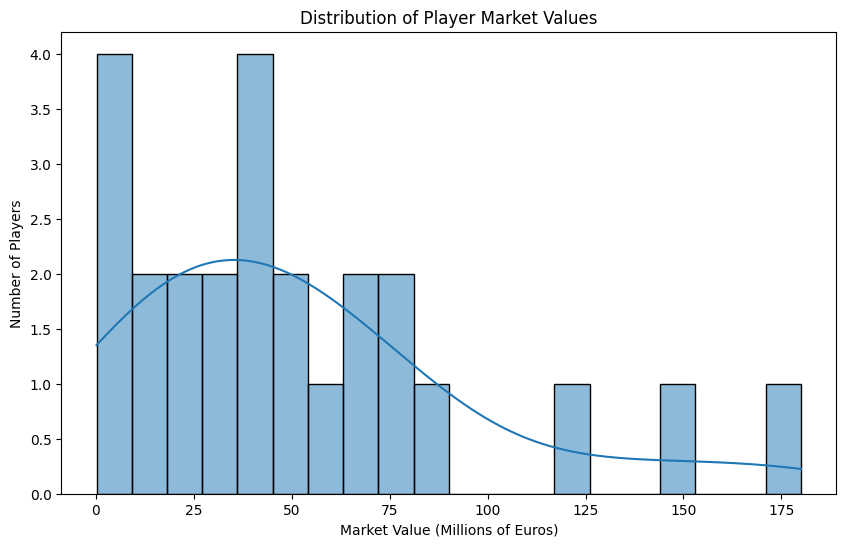

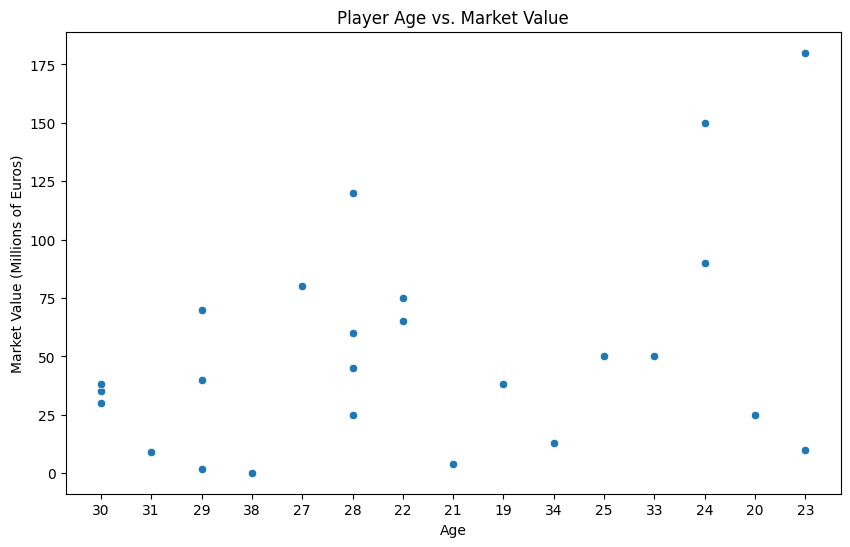

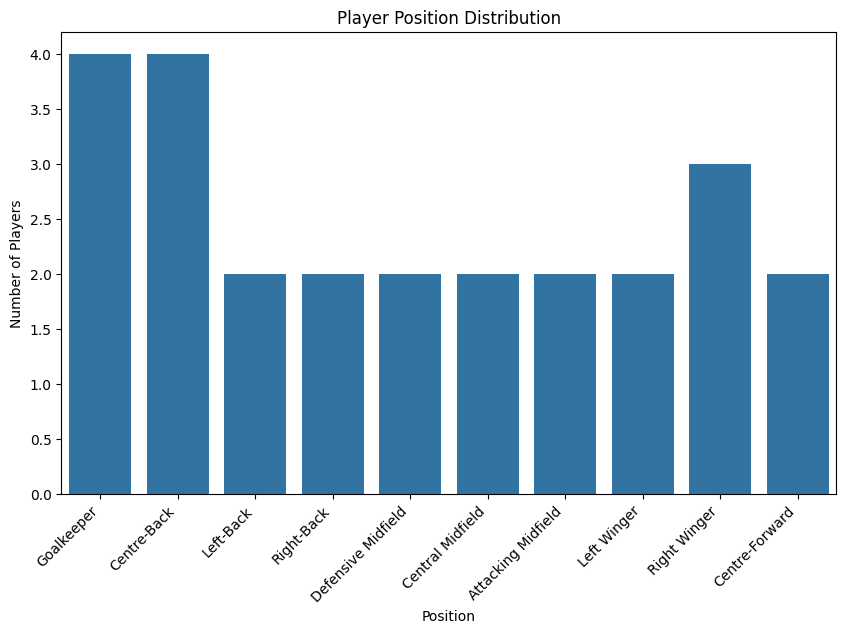

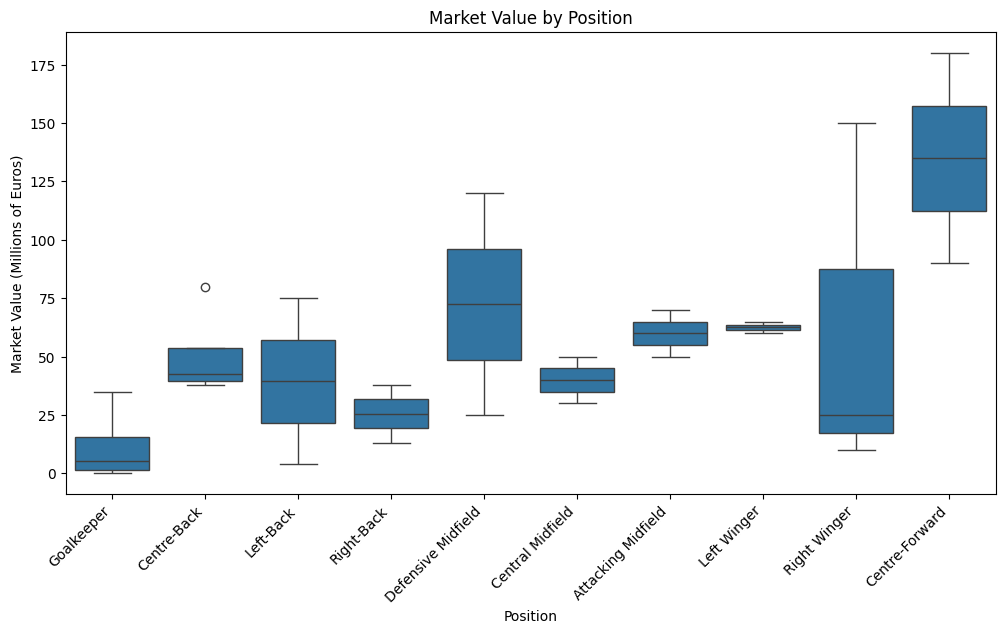

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Player Market Values
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['Market value(in Millions))'], bins=20, kde=True)
plt.title('Distribution of Player Market Values')
plt.xlabel('Market Value (Millions of Euros)')
plt.ylabel('Number of Players')
plt.show()

# Player Age vs. Market Value
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Market value(in Millions)', data=cleaned_df)
plt.title('Player Age vs. Market Value')
plt.xlabel('Age')
plt.ylabel('Market Value (Millions of Euros)')

plt.show()

# Player Position Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Position', data=cleaned_df)
plt.title('Player Position Distribution')
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.show()

# Market Value by Position (Box Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Position', y='Market value(in Millions)', data=cleaned_df)
plt.title('Market Value by Position')
plt.xlabel('Position')
plt.ylabel('Market Value (Millions of Euros)')
plt.xticks(rotation=45, ha='right')
plt.show()
